# Libraries

In [ ]:
import copy
import random
import cv2
import numpy as np
import dlib
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# The Notebook for Style transfer could be found by the link

/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/JoJoGAN_stylize.ipynb

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00


In [ ]:
#@title Setup. This will take a few minutes.
!git clone https://github.com/mchong6/JoJoGAN.git
%cd JoJoGAN
!pip install tqdm gdown scikit-learn==0.22 scipy lpips dlib opencv-python wandb
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/content/JoJoGAN/util.py')
sys.path.append('/content/JoJoGAN/model.py')
sys.path.append('/content/JoJoGAN/e4e_projection.py')

from google.colab import drive
drive.mount('/content/gdrive')

import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import wandb
from model import *
from e4e_projection import projection as e4e_projection

from google.colab import files
from copy import deepcopy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)

Cloning into 'JoJoGAN'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 490 (delta 31), reused 31 (delta 31), pack-reused 450
Receiving objects: 100% (490/490), 63.51 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (203/203), done.
/content/JoJoGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 7.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
ERROR: Could not build wheels for scikit-learn, which is required to install pyproject.toml-based

In [ ]:
#@title Download models

download_with_pydrive = True
device = 'cuda'

!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
%matplotlib inline


drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "sketch_multi.pt": "1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

# from StyelGAN-NADA
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            if self.use_pydrive:
                downloaded = self.drive.CreateFile({'id':file_id})
                downloaded.FetchMetadata(fetch_all=True)
                downloaded.GetContentFile(file_dst)
            else:
                !gdown --id $file_id -O $file_dst



downloader = Downloader(download_with_pydrive)

downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)


transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

--2024-01-22 14:13:44--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  18.3MB/s    in 3.3s    

2024-01-22 14:13:48 (18.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



# Selfie

In [ ]:
selfie_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/004.jpg'

# Using an Uploaded Model to Stylize a Selfie Image FRIDA

In [ ]:
# Load the model weights
model_load_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/finetuned_generator_Frida.pth'

generator = torch.load(model_load_path)

In [ ]:
artwork_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/Self-Portrait-with-Thorn-Necklace-and-Hummingbird-Frida-Kahlo.jpg'

In [ ]:
selfie = cv2.imread(selfie_path)
artwork = cv2.imread(artwork_path)

In [ ]:
# cv2_imshow(selfie)

In [ ]:
plt.rcParams['figure.dpi'] = 150

filepath = selfie_path
# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

# display_image(aligned_face, title='Aligned face')

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


In [ ]:
#@title Generate results
# Generate a single sample
seed = 3000
torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    my_sample = generator(my_w, input_is_latent=True)

# # Display the aligned face image
# display_image(aligned_face, title='Aligned face')

# Display the generated image from my_sample
# display_image(my_sample, title='My sample')

/content/JoJoGAN/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.1.0+cu121. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


In [ ]:
from torchvision.transforms.functional import to_pil_image

if my_sample.is_cuda:
    my_sample = my_sample.cpu()
my_sample = my_sample.squeeze(0)  # Remove batch dimension if there is one
my_sample = (my_sample + 1) / 2  # Normalize to [0, 1]
my_sample = torch.clamp(my_sample, 0, 1)  # Clamp values to [0, 1]
my_sample_pil = to_pil_image(my_sample)

# Save the image using PIL
styled_selfie_path = '/content/selfie_styled.jpg'
my_sample_pil.save(styled_selfie_path)

print(f"Image saved to {styled_selfie_path}")

Image saved to /content/selfie_styled.jpg


# Triangulation FRIDA

In [ ]:
# Downloading shape_predictor
!wget 'https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat'

--2024-01-22 14:16:53--  https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat [following]
--2024-01-22 14:16:53--  https://raw.githubusercontent.com/tzutalin/dlib-android/master/data/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M   155MB/s    in 0.6s  

In [ ]:
# Extracting index from array
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

**Face Swap**

In [ ]:
styled_selfie_path = '/content/selfie_styled.jpg'
styled_selfie = cv2.imread(styled_selfie_path)

img = np.array(styled_selfie)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
print(mask.shape)
img2 = np.array(artwork)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# cv2_imshow(img)
# cv2_imshow(img2)

(1024, 1024)


In [ ]:
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.5

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

In [ ]:
# Face 1
faces = detector(img_gray)
print(faces)

all_points = ALIGN_POINTS[:]
for feature in OVERLAY_POINTS:
    all_points.extend(feature)

# Now, all_points is a flat list of integers

# Modify the landmark processing
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []

    # Iterate over each individual point
    for n in all_points:
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))
        # cv2.circle(img=img, center=(x, y), radius=3, color=(0, 255, 0), thickness=-1)

    points = np.array(landmarks_points, np.int32)
    #print(points)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)
    #print(face_image_1)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)

# faces

rectangles[[(199, 270) (841, 912)]]


In [ ]:
# Face 2
all_points = ALIGN_POINTS[:]
for feature in OVERLAY_POINTS:
    all_points.extend(feature)

# Flatten the list of points correctly
# Now, all_points is a flat list of integers

# Processing for Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []

    # Iterate over the flattened list of points for the second face
    for n in all_points:
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))

    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)

faces2

rectangles[[(112, 161) (261, 311)]]

In [ ]:
# Creating empty mask
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

In [ ]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1

    if w <= 0 or h <= 0:
        continue

    cropped_triangle = img[y: y + h, x: x + w]
    if cropped_triangle.shape[0] <= 0 or cropped_triangle.shape[1] <= 0:
        continue
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    if w <= 0 or h <= 0:
        continue
    y = max(0, y)
    x = max(0, x)
    h = min(img2_new_face.shape[0] - y, h)
    w = min(img2_new_face.shape[1] - x, w)

    if w <= 0 or h <= 0:
        continue
    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

In [ ]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)

In [ ]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)
# cv2_imshow(result)

In [ ]:
# Creating seamless clone of two faces
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone_frida = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

# FRIDA result

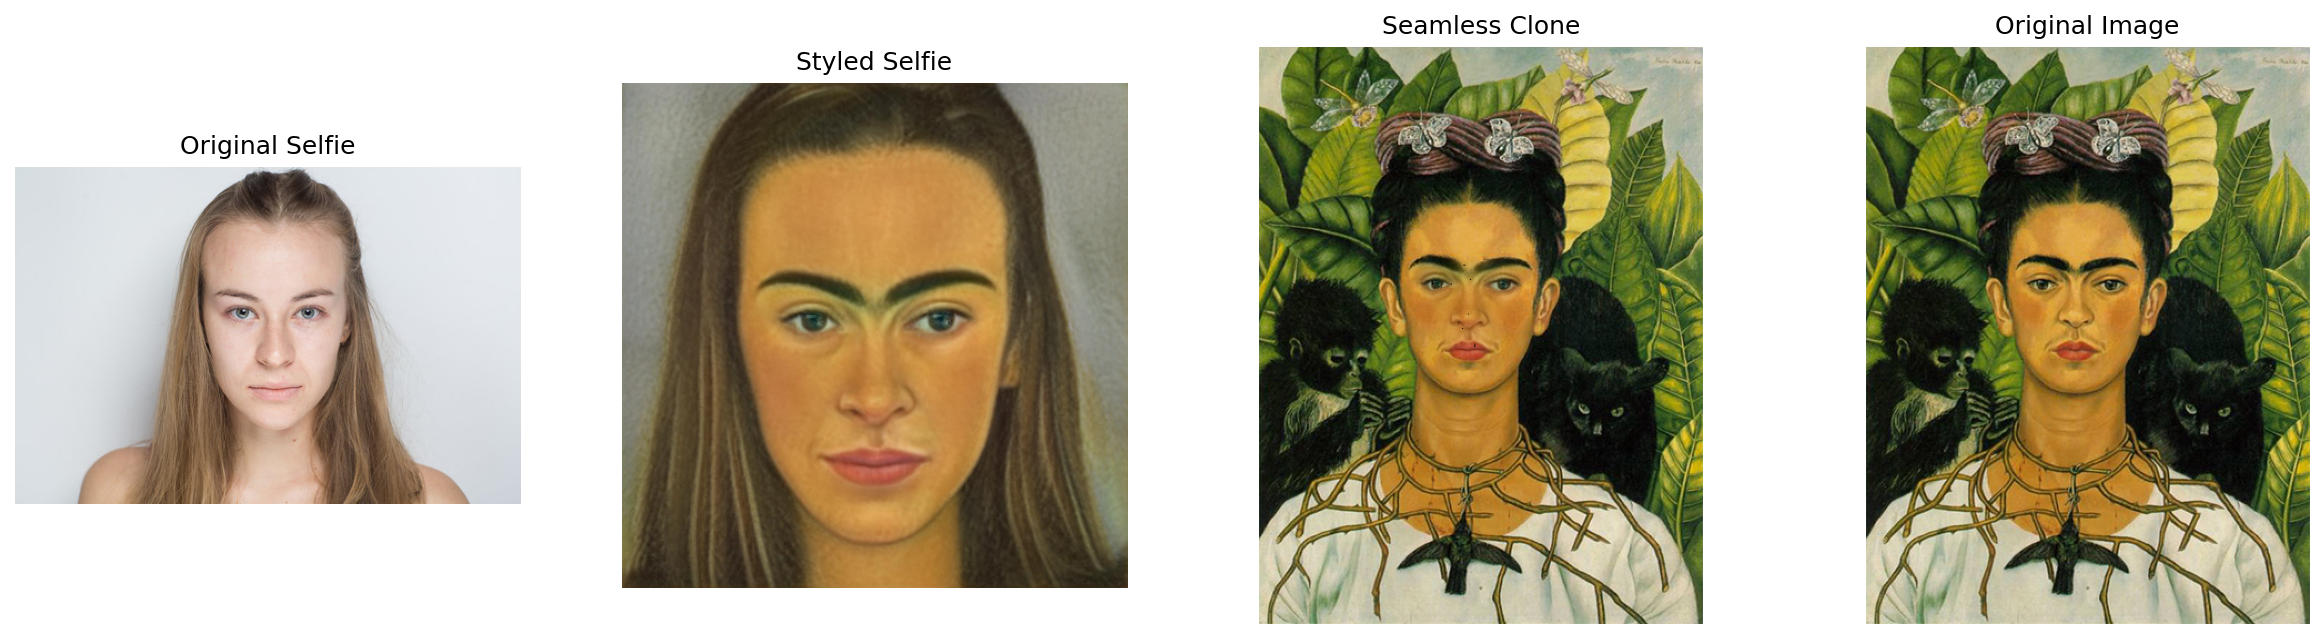

In [ ]:
# Convert BGR images to RGB for matplotlib
selfie_rgb = cv2.cvtColor(selfie, cv2.COLOR_BGR2RGB)
styled_selfie_rgb = cv2.cvtColor(styled_selfie, cv2.COLOR_BGR2RGB)
seamlessclone_rgb = cv2.cvtColor(seamlessclone_frida, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Plotting
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed

# Display the original selfie
plt.subplot(1, 4, 1)  # 1 row, 4 columns, 1st subplot
plt.imshow(selfie_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Original Selfie')

# Display the styled selfie
plt.subplot(1, 4, 2)  # 1 row, 4 columns, 2nd subplot
plt.imshow(styled_selfie_rgb)
plt.axis('off')
plt.title('Styled Selfie')

# Display the seamless clone image
plt.subplot(1, 4, 3)  # 1 row, 4 columns, 3rd subplot
plt.imshow(seamlessclone_rgb)
plt.axis('off')
plt.title('Seamless Clone')

# Display the second image
plt.subplot(1, 4, 4)  # 1 row, 4 columns, 4th subplot
plt.imshow(img2_rgb)
plt.axis('off')
plt.title('Original Image')

plt.show()

In [ ]:
# Save the seamless clone image as a JPG file
output_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/After_triangulation/Frida_inplace.jpg'
cv2.imwrite(output_path, seamlessclone_frida)

True

# Using an Uploaded Model to Stylize a Selfie Image KOROVIN

In [ ]:
# Load the model weights
model_load_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/finetuned_generator_Korovin.pth'

generator = torch.load(model_load_path)

In [ ]:
artwork_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/Horistka_Korovin.jpg'

In [ ]:
selfie = cv2.imread(selfie_path)
artwork = cv2.imread(artwork_path)

In [ ]:
# cv2_imshow(selfie)

In [ ]:
plt.rcParams['figure.dpi'] = 150

filepath = selfie_path
# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

# display_image(aligned_face, title='Aligned face')

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


In [ ]:
#@title Generate results
# Generate a single sample
seed = 3000
torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    my_sample = generator(my_w, input_is_latent=True)

# # Display the aligned face image
# display_image(aligned_face, title='Aligned face')

# Display the generated image from my_sample
# display_image(my_sample, title='My sample')

In [ ]:
from torchvision.transforms.functional import to_pil_image

if my_sample.is_cuda:
    my_sample = my_sample.cpu()
my_sample = my_sample.squeeze(0)  # Remove batch dimension if there is one
my_sample = (my_sample + 1) / 2  # Normalize to [0, 1]
my_sample = torch.clamp(my_sample, 0, 1)  # Clamp values to [0, 1]
my_sample_pil = to_pil_image(my_sample)

# Save the image using PIL
styled_selfie_path = '/content/selfie_styled_Korovin.jpg'
my_sample_pil.save(styled_selfie_path)

print(f"Image saved to {styled_selfie_path}")

Image saved to /content/selfie_styled_Korovin.jpg


# Triangulation KOROVIN

**Face Swap**

In [ ]:
styled_selfie_path = '/content/selfie_styled_Korovin.jpg'
styled_selfie = cv2.imread(styled_selfie_path)

img = np.array(styled_selfie)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
print(mask.shape)
img2 = np.array(artwork)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# cv2_imshow(img)
# cv2_imshow(img2)

(1024, 1024)


In [ ]:
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.5

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

In [ ]:
# Face 1
faces = detector(img_gray)
print(faces)

all_points = ALIGN_POINTS[:]
for feature in OVERLAY_POINTS:
    all_points.extend(feature)

# Now, all_points is a flat list of integers

# Modify the landmark processing
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []

    # Iterate over each individual point
    for n in all_points:
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))
        # cv2.circle(img=img, center=(x, y), radius=3, color=(0, 255, 0), thickness=-1)

    points = np.array(landmarks_points, np.int32)
    #print(points)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)
    #print(face_image_1)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)

# faces

rectangles[[(199, 270) (841, 912)]]


In [ ]:
# Face 2
all_points = ALIGN_POINTS[:]
for feature in OVERLAY_POINTS:
    all_points.extend(feature)

# Flatten the list of points correctly
# Now, all_points is a flat list of integers

# Processing for Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []

    # Iterate over the flattened list of points for the second face
    for n in all_points:
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))

    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)

faces2

rectangles[[(281, 257) (496, 472)]]

In [ ]:
# Creating empty mask
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

In [ ]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1

    if w <= 0 or h <= 0:
        continue

    cropped_triangle = img[y: y + h, x: x + w]
    if cropped_triangle.shape[0] <= 0 or cropped_triangle.shape[1] <= 0:
        continue
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    if w <= 0 or h <= 0:
        continue
    y = max(0, y)
    x = max(0, x)
    h = min(img2_new_face.shape[0] - y, h)
    w = min(img2_new_face.shape[1] - x, w)

    if w <= 0 or h <= 0:
        continue
    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

In [ ]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)

In [ ]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)
# cv2_imshow(result)

In [ ]:
# Creating seamless clone of two faces
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone_korovin = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

# KOROVIN result

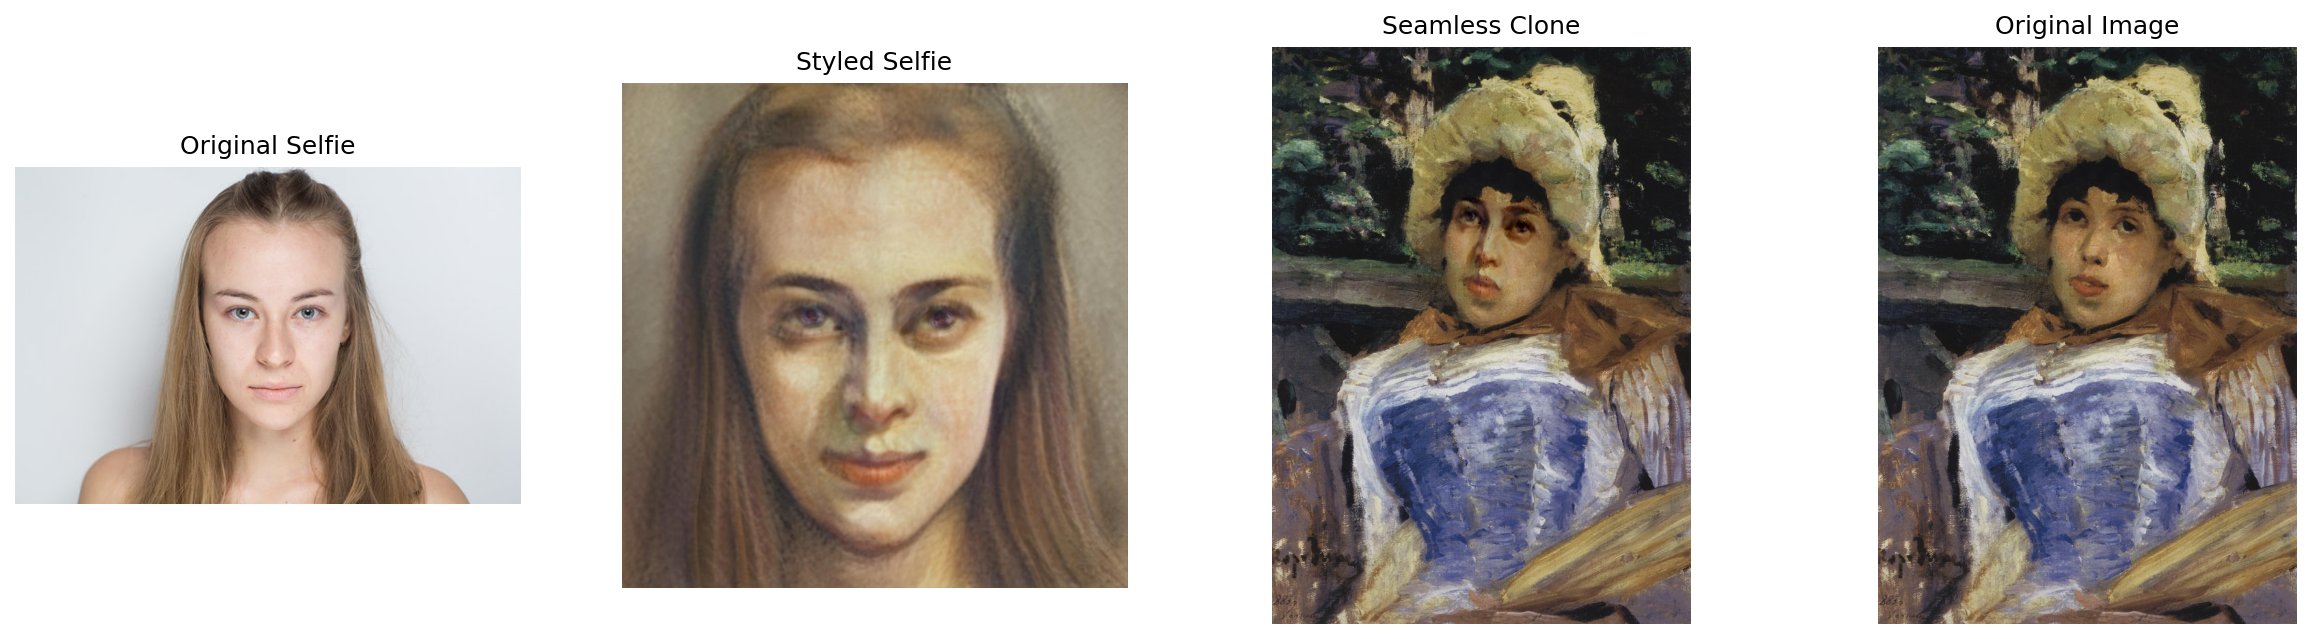

In [ ]:
# Convert BGR images to RGB for matplotlib
selfie_rgb = cv2.cvtColor(selfie, cv2.COLOR_BGR2RGB)
styled_selfie_rgb = cv2.cvtColor(styled_selfie, cv2.COLOR_BGR2RGB)
seamlessclone_rgb = cv2.cvtColor(seamlessclone_korovin, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Plotting
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed

# Display the original selfie
plt.subplot(1, 4, 1)  # 1 row, 4 columns, 1st subplot
plt.imshow(selfie_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Original Selfie')

# Display the styled selfie
plt.subplot(1, 4, 2)  # 1 row, 4 columns, 2nd subplot
plt.imshow(styled_selfie_rgb)
plt.axis('off')
plt.title('Styled Selfie')

# Display the seamless clone image
plt.subplot(1, 4, 3)  # 1 row, 4 columns, 3rd subplot
plt.imshow(seamlessclone_rgb)
plt.axis('off')
plt.title('Seamless Clone')

# Display the second image
plt.subplot(1, 4, 4)  # 1 row, 4 columns, 4th subplot
plt.imshow(img2_rgb)
plt.axis('off')
plt.title('Original Image')

plt.show()

In [ ]:
# Save the seamless clone image as a JPG file
output_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/After_triangulation/Korovin_inplace.jpg'
cv2.imwrite(output_path, seamlessclone_korovin)

True

# Using an Uploaded Model to Stylize a Selfie Image BOROVIKOVSKY

In [ ]:
# Load the model weights
model_load_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/finetuned_generator_Borovikovsky.pth'

generator = torch.load(model_load_path)

In [ ]:
artwork_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/Orlova-Denisova_Borovik.jpg'

In [ ]:
selfie = cv2.imread(selfie_path)
artwork = cv2.imread(artwork_path)

In [ ]:
plt.rcParams['figure.dpi'] = 150

filepath = selfie_path
# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

# display_image(aligned_face, title='Aligned face')

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


In [ ]:
#@title Generate results
# Generate a single sample
seed = 3000
torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    my_sample = generator(my_w, input_is_latent=True)

# # Display the aligned face image
# display_image(aligned_face, title='Aligned face')

# Display the generated image from my_sample
# display_image(my_sample, title='My sample')

In [ ]:
from torchvision.transforms.functional import to_pil_image

if my_sample.is_cuda:
    my_sample = my_sample.cpu()
my_sample = my_sample.squeeze(0)  # Remove batch dimension if there is one
my_sample = (my_sample + 1) / 2  # Normalize to [0, 1]
my_sample = torch.clamp(my_sample, 0, 1)  # Clamp values to [0, 1]
my_sample_pil = to_pil_image(my_sample)

# Save the image using PIL
styled_selfie_path = '/content/selfie_styled_Borovikovsky.jpg'
my_sample_pil.save(styled_selfie_path)

print(f"Image saved to {styled_selfie_path}")

Image saved to /content/selfie_styled_Borovikovsky.jpg


# Triangulation BOROVIKOVSKY

**Face Swap**

In [ ]:
styled_selfie_path = '/content/selfie_styled_Borovikovsky.jpg'
styled_selfie = cv2.imread(styled_selfie_path)

img = np.array(styled_selfie)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
print(mask.shape)
img2 = np.array(artwork)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# cv2_imshow(img)
# cv2_imshow(img2)

(1024, 1024)


In [ ]:
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.5

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

In [ ]:
# Face 1
faces = detector(img_gray)
print(faces)

all_points = ALIGN_POINTS[:]
for feature in OVERLAY_POINTS:
    all_points.extend(feature)

# Now, all_points is a flat list of integers

# Modify the landmark processing
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []

    # Iterate over each individual point
    for n in all_points:
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))
        # cv2.circle(img=img, center=(x, y), radius=3, color=(0, 255, 0), thickness=-1)

    points = np.array(landmarks_points, np.int32)
    #print(points)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)
    #print(face_image_1)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)

# faces

rectangles[[(199, 270) (841, 912)]]


In [ ]:
# Face 2
all_points = ALIGN_POINTS[:]
for feature in OVERLAY_POINTS:
    all_points.extend(feature)

# Flatten the list of points correctly
# Now, all_points is a flat list of integers

# Processing for Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []

    # Iterate over the flattened list of points for the second face
    for n in all_points:
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))

    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)

faces2

rectangles[[(277, 178) (427, 327)]]

In [ ]:
# Creating empty mask
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

In [ ]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1

    if w <= 0 or h <= 0:
        continue

    cropped_triangle = img[y: y + h, x: x + w]
    if cropped_triangle.shape[0] <= 0 or cropped_triangle.shape[1] <= 0:
        continue
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    if w <= 0 or h <= 0:
        continue
    y = max(0, y)
    x = max(0, x)
    h = min(img2_new_face.shape[0] - y, h)
    w = min(img2_new_face.shape[1] - x, w)

    if w <= 0 or h <= 0:
        continue
    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

In [ ]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)

In [ ]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)
# cv2_imshow(result)

In [ ]:
# Creating seamless clone of two faces
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone_borovikovsky = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

# BOROVIKOVSKY result

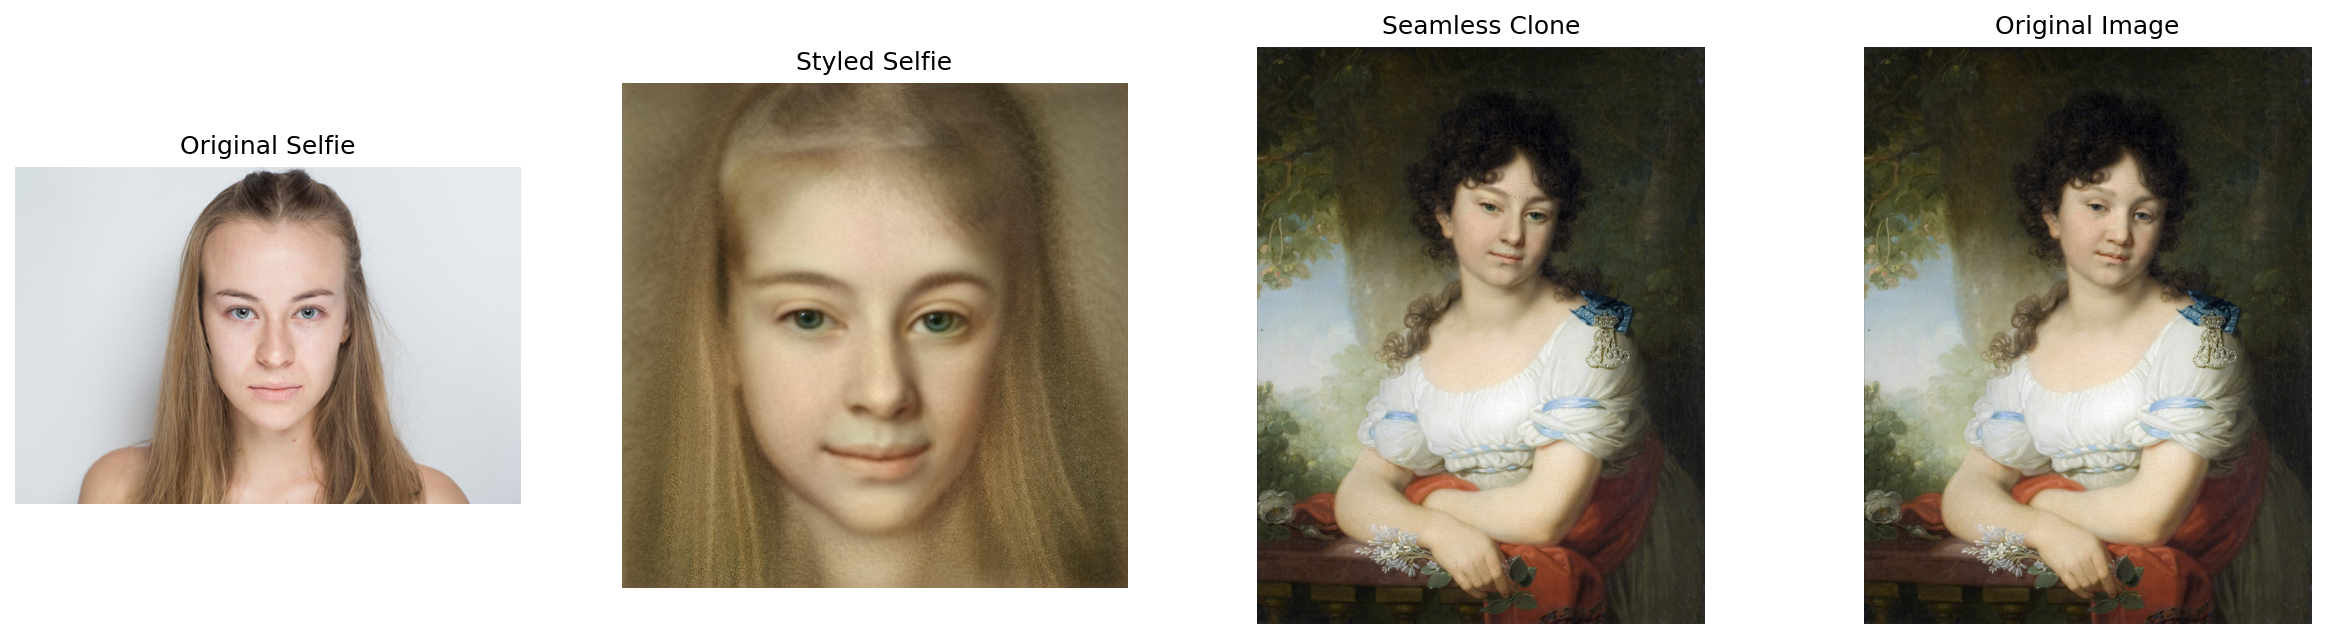

In [ ]:
# Convert BGR images to RGB for matplotlib
selfie_rgb = cv2.cvtColor(selfie, cv2.COLOR_BGR2RGB)
styled_selfie_rgb = cv2.cvtColor(styled_selfie, cv2.COLOR_BGR2RGB)
seamlessclone_rgb = cv2.cvtColor(seamlessclone_borovikovsky, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Plotting
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed

# Display the original selfie
plt.subplot(1, 4, 1)  # 1 row, 4 columns, 1st subplot
plt.imshow(selfie_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Original Selfie')

# Display the styled selfie
plt.subplot(1, 4, 2)  # 1 row, 4 columns, 2nd subplot
plt.imshow(styled_selfie_rgb)
plt.axis('off')
plt.title('Styled Selfie')

# Display the seamless clone image
plt.subplot(1, 4, 3)  # 1 row, 4 columns, 3rd subplot
plt.imshow(seamlessclone_rgb)
plt.axis('off')
plt.title('Seamless Clone')

# Display the second image
plt.subplot(1, 4, 4)  # 1 row, 4 columns, 4th subplot
plt.imshow(img2_rgb)
plt.axis('off')
plt.title('Original Image')

plt.show()

In [ ]:
# Save the seamless clone image as a JPG file
output_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/After_triangulation/Borovikovsky_inplace.jpg'
cv2.imwrite(output_path, seamlessclone_borovikovsky)

True

# For the final step, we will correct any artifacts on the faces and then generate the final images.

The following Colab was used as a reference: https://colab.research.google.com/drive/1sVsoBd9AjckIXThgtZhGrHRfFI6UUYOo?usp=sharing&hl=en#scrollTo=d6CkQ2x-eSjH

In [ ]:
# Clone GFPGAN and enter the GFPGAN folder
%cd /content
!rm -rf GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN

# Set up the environment
# Install basicsr - https://github.com/xinntao/BasicSR
# We use BasicSR for both training and inference
!pip install basicsr
# Install facexlib - https://github.com/xinntao/facexlib
# We use face detection and face restoration helper in the facexlib package
!pip install facexlib
# Install other depencencies
!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan  # used for enhancing the background (non-face) regions
# Download the pre-trained model
# !wget https://github.com/TencentARC/GFPGAN/releases/download/v0.2.0/GFPGANCleanv1-NoCE-C2.pth -P experiments/pretrained_models
# Now we use the V1.3 model for the demo
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

/content
Cloning into 'GFPGAN'...
remote: Enumerating objects: 523, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 523 (delta 168), reused 153 (delta 153), pack-reused 313
Receiving objects: 100% (523/523), 5.37 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (279/279), done.
/content/GFPGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.3 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=1a24f938dcac6e771fb2debc13b17f01e923ce36a401d27b8be43a6f49f0f2c7
  Stored in directory: /root/.cache/pi

In [ ]:
# upload your own images
import os
from google.colab import files
import shutil

upload_folder = 'inputs/upload'

# Google Drive folder containing images
drive_folder = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/After_triangulation'

# Clear the upload folder if it exists, then create it
if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.mkdir(upload_folder)

# List all files in the Google Drive folder
image_files = [f for f in os.listdir(drive_folder) if os.path.isfile(os.path.join(drive_folder, f))]

# Copy each file to the upload folder
for filename in image_files:
    src_path = os.path.join(drive_folder, filename)
    dst_path = os.path.join(upload_folder, filename)
    print(f'Copying {filename} to {dst_path}')
    shutil.copy(src_path, dst_path)

Copying Frida_inplace.jpg to inputs/upload/Frida_inplace.jpg
Copying Korovin_inplace.jpg to inputs/upload/Korovin_inplace.jpg
Copying Borovikovsky_inplace.jpg to inputs/upload/Borovikovsky_inplace.jpg


In [ ]:
# Now we use the GFPGAN to restore the above low-quality images
# We use [Real-ESRGAN](https://github.com/xinntao/Real-ESRGAN) for enhancing the background (non-face) regions
# You can find the different models in https://github.com/TencentARC/GFPGAN#european_castle-model-zoo
!rm -rf results
!python inference_gfpgan.py -i inputs/upload -o results -v 1.3 -s 2 --bg_upsampler realesrgan

# Usage: python inference_gfpgan.py -i inputs/whole_imgs -o results -v 1.3 -s 2 [options]...
#
#  -h                   show this help
#  -i input             Input image or folder. Default: inputs/whole_imgs
#  -o output            Output folder. Default: results
#  -v version           GFPGAN model version. Option: 1 | 1.2 | 1.3. Default: 1.3
#  -s upscale           The final upsampling scale of the image. Default: 2
#  -bg_upsampler        background upsampler. Default: realesrgan
#  -bg_tile             Tile size for background sampler, 0 for no tile during testing. Default: 400
#  -suffix              Suffix of the restored faces
#  -only_center_face    Only restore the center face
#  -aligned             Input are aligned faces
#  -ext                 Image extension. Options: auto | jpg | png, auto means using the same extension as inputs. Default: auto

!ls results/cmp

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth" to /usr/local/lib/python3.10/dist-packages/weights/RealESRGAN_x2plus.pth

100% 64.0M/64.0M [00:00<00:00, 277MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the fu

# Final Images

In [ ]:
# We then visualize the whole image
# The left are the inputs images; the right are the results of GFPGAN

import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('GFPGAN output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob

input_folder = 'inputs/upload'
result_folder = 'results/restored_imgs'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# download the result
!ls results
print('Download results')
os.system('zip -r download.zip results')
files.download("download.zip")

cmp  cropped_faces  restored_faces  restored_imgs
Download results


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Отчет о Проекте

https://drive.google.com/drive/folders/1dCxEfWJQGFyOUGSRxUba9_5t-UzEQDE1?usp=drive_link

**Задача проекта:**

В рамках проекта была поставлена задача интеграции лица с фотографии в изображение известного произведения искусства. Целью было выбрать три художественных произведения и разработать процесс адаптации селфи под стиль каждой картины, а затем выполнить вписывание лица в эти произведения. Задача была успешно выполнена, и в результате получились три уникальных изображения, где одно и то же селфи вписано в разные картины.

**Процесс:**

Процесс реализации проекта включал в себя несколько этапов:

- Предварительная подготовка с помощью StyleGAN: Модель StyleGAN была предварительно обучена на выбранных произведениях искусства, затем использовалась для стилизации селфи под эти картины. Процесс обучения модели доступен по ссылке

/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/JoJoGAN_stylize.ipynb.

- Триангуляция для переноса лица: Используя метод триангуляции, был выполнен перенос лица с селфи на произведение искусства. Этот подход эффективно позволил адаптировать фронтальное селфи к портрету, даже если оригинальное изображение было в ракурсе.

- Финальная обработка с GFPGAN: Применение модели GFPGAN позволило доработать полученные изображения, устранить артефакты и повысить качество лицевых изображений. Данный этап можно просмотреть в ноутбуке

/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/12_Museum_face_recognition/Shared_folder_Museum_project/GFPGAN_inference_final_tuning.ipynb.

**Выводы:**

- GAN-модели демонстрируют себя как мощный инструмент для работы с изображениями.
- Модель JoJoGAN, использованная для стилизации, эффективно передавала стиль художников, но лица теряли свою уникальность, что в дальнейшем влияло на узнаваемость.

- Триангуляция лиц дополнительно изменяла черты, уменьшая узнаваемость оригинального селфи.
- Применение GFPGAN значительно улучшило качество изображения и удалило артефакты, сохраняя при этом стиль.

**Дальнейшие шаги:**

Для сохранения узнаваемости лиц в дальнейшем можно рассмотреть альтернативные модели стилизации, возможно, более точные в сохранении черт лица.

# Project Objective:

https://drive.google.com/drive/folders/1dCxEfWJQGFyOUGSRxUba9_5t-UzEQDE1?usp=drive_link

The project aimed to integrate a face from a photograph into a famous artwork. The goal was to select three artistic pieces and develop a process to adapt a selfie to the style of each painting, followed by incorporating the face into these artworks. This objective was successfully met, resulting in three unique images where the same selfie was integrated into different paintings.

**Process:**

**The implementation of the project involved several stages:**

- Preliminary Preparation with StyleGAN: The StyleGAN model was pre-trained on selected artworks and then used for styling the selfie to match these paintings. The model training process is available in the StyleGAN Training Notebook.

- Face Transfer via Triangulation: Using the method of triangulation, the face was transferred from the selfie to the artwork. This approach effectively adapted a frontal selfie to a portrait, even when the original image had a different angle.

- Final Processing with GFPGAN: The use of the GFPGAN model allowed for refining the resulting images, removing artifacts, and enhancing the quality of the facial images. This stage can be viewed in the GFPGAN Processing Notebook.

**Conclusions:**

- GAN models have proven to be a powerful tool for image processing.
- The JoJoGAN model, used for styling, effectively conveyed the style of artists, but faces lost their uniqueness, affecting recognizability.
- Face triangulation further altered features, reducing the recognizability of the original selfie.
- The application of GFPGAN significantly improved image quality and removed artifacts while maintaining the style.

**Future Steps:**

To preserve facial recognizability in future works, alternative styling models could be explored, potentially more accurate in retaining facial features.